In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()
import tarfile
from six.moves import urllib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# download california housing price dataset
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
# code for downloading the dataset
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        urllib.request.urlretrieve(housing_url, tgz_path)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()

In [4]:
# download data
fetch_housing_data()

In [5]:
# read dataset
csv_path = os.path.join(HOUSING_PATH, "housing.csv")
df = pd.read_csv(csv_path)
df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DD9E9A3208>,
      dtype=object)

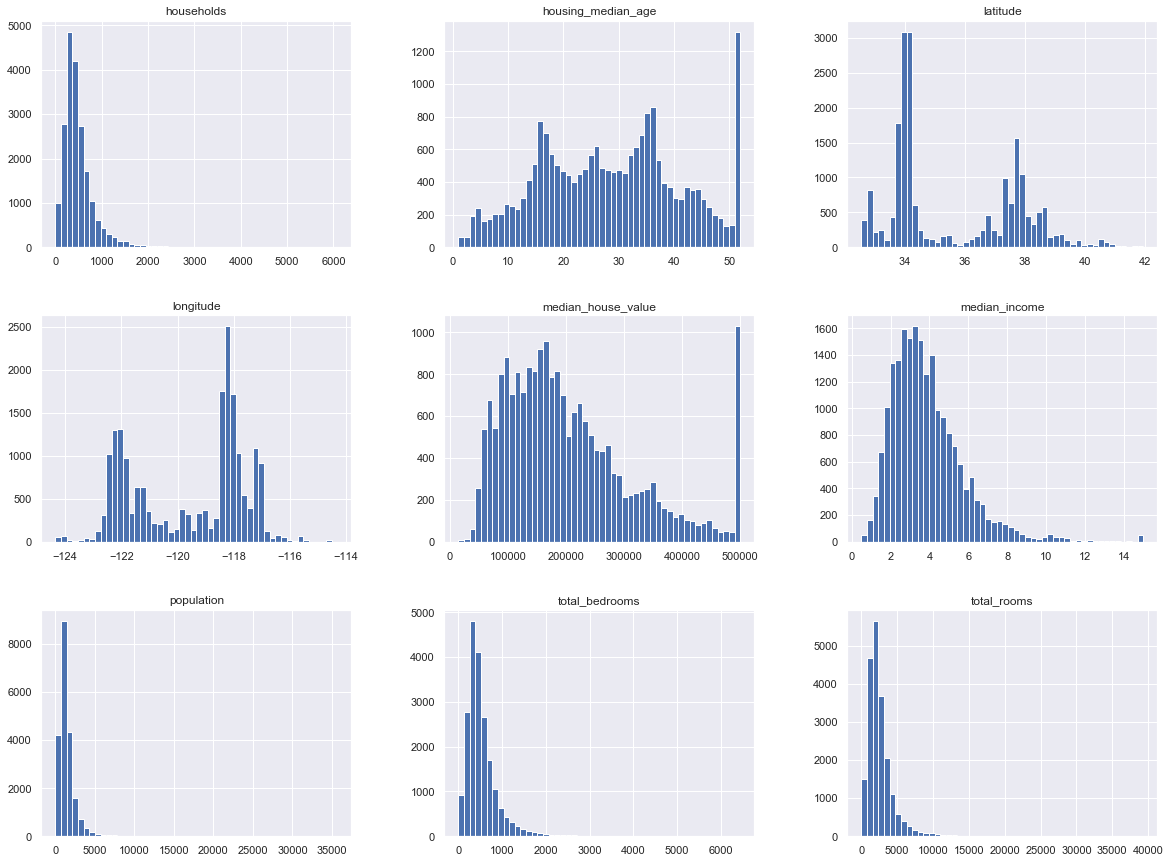

In [9]:
# plot histogram
df.hist(bins=50, figsize=(20,15))

In [10]:
# add index label as unique identifier
df = df.reset_index()
df.head(2)

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY


In [11]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

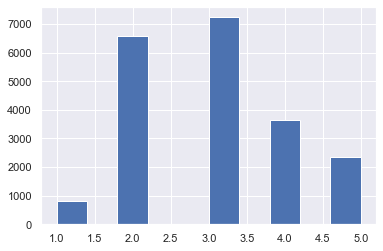

In [12]:
# median income is a very important attribute to predict median housing prices
# ensureing that the test set is representative of the various categories of incomes in the whole dataset
df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf],labels=[1, 2, 3, 4, 5])
df['income_cat'].hist()

In [13]:
# stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [14]:
# remove income cat columns
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [15]:
# create copy of train dataset
housing = strat_train_set.copy()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


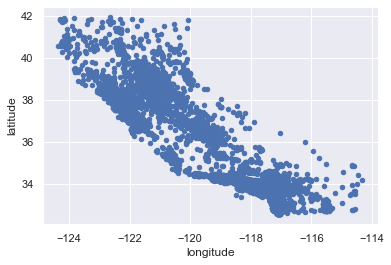

In [16]:
housing.plot(kind="scatter", x="longitude", y="latitude")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


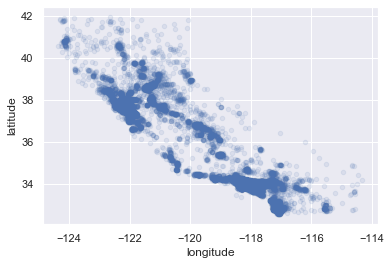

In [17]:
housing.plot(kind="scatter", x="longitude", y="latitude",alpha=0.1)

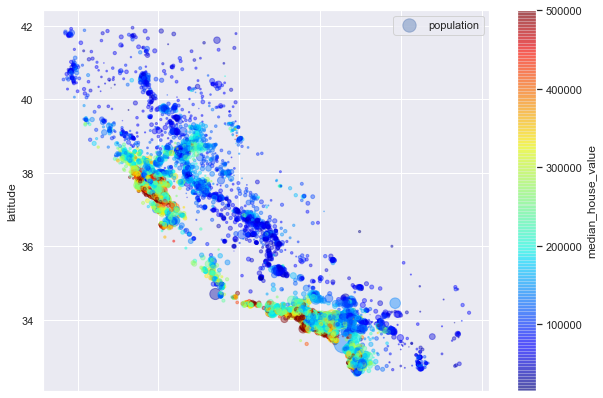

In [18]:
# The radius of each circle represents the district’s population (option s), 
# and the color represents the price (option c)

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)

In [19]:
# checking corrleation
# The correlation coefficient only measures linear correlations 
# (“if x goes up, then y generally goes up/down”). 
# It may completely miss out on nonlinear relationships 
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
index                 0.067723
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

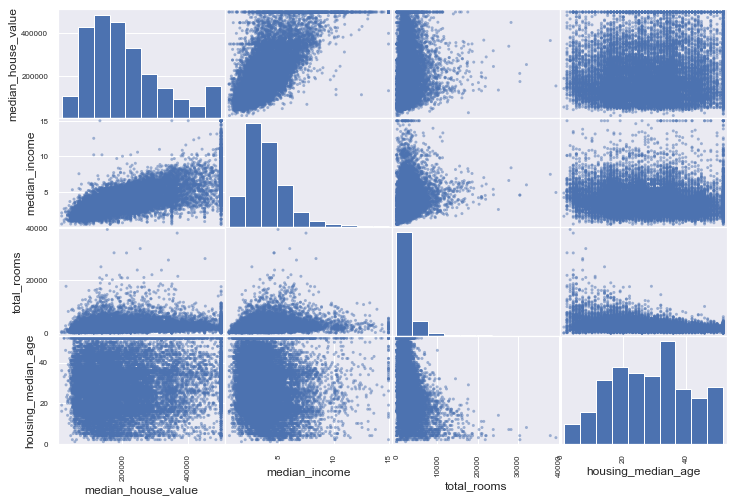

In [20]:
# scattered pair plot 
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8));

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


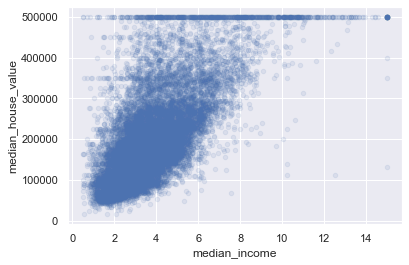

In [21]:
# most promising attribute to predict the median house value is the median income
# so let’s zoom in on their correlation scatterplot 
housing.plot(kind="scatter", x="median_income", y="median_house_value",alpha=0.1)

In [22]:
# feature engineering
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [23]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
index                       0.067723
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [24]:
# separate X and Y 
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [25]:
# impute missing values using median for all numerical attribute
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
imputer.statistics_

array([ 1.0341e+04, -1.1851e+02,  3.4260e+01,  2.9000e+01,  2.1195e+03,
        4.3300e+02,  1.1640e+03,  4.0800e+02,  3.5409e+00])

In [26]:
# input training data
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [27]:
# one hot encoding categorical variables
cat_encoder = OneHotEncoder()
housing_cat = housing[["ocean_proximity"]]
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [28]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [29]:
# create custom estimater
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        # index of features
        rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [30]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [31]:
# create sklearn pipeline 

# create pipeline for numeric attributes
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler()),])

# creare pipeline for categorical attributes
num_attribs = list(housing_num.columns)
cat_attribs = ["ocean_proximity"]

# create full pipeline
full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs),
                                   ("cat", OneHotEncoder(), cat_attribs),])

In [32]:
full_pipeline.fit(housing)
housing_prepared = full_pipeline.transform(housing)

In [33]:
housing_prepared

array([[ 1.21647303, -1.15604281,  0.77194962, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.38806524, -1.17602483,  0.6596948 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72210015,  1.18684903, -1.34218285, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.59800519,  1.58648943, -0.72478134, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.13825179,  0.78221312, -0.85106801, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.9102495 , -1.43579109,  0.99645926, ...,  0.        ,
         1.        ,  0.        ]])

In [34]:
# fit model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
# check pipeline on few datasets
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [219561.99623447 323998.93524398 215492.58562019  53233.387825
 190532.59786521]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [36]:
# check rmse
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68336.84121369653

In [37]:
# tree based regressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [38]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [39]:
# cross validation on Tree

# cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better)
# hence we will used negative rmse instead of rmse
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)

In [40]:
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([63969.40865644, 65807.4218681 , 67920.31494501, 71114.07686819,
       70410.49020131, 74085.52272591, 64944.67370241, 67356.98701132,
       70596.46637138, 72681.23592538])

In [41]:
tree_rmse_scores.mean()

68888.65982754498

In [42]:
tree_rmse_scores.std()

3226.575099926262

In [43]:
# cross validation on linear regression
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [44]:
lin_rmse_scores.mean()

68627.92001896758

In [45]:
lin_rmse_scores.std()

2285.0575955824424

In [46]:
# random forest regressor
forest_reg = RandomForestRegressor()
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [47]:
forest_rmse_scores.mean(),forest_rmse_scores.std()

(49806.465939156995, 2067.5783475891535)

In [48]:
# Grid Search Hyperparameter tunning for Random Forest

# param_grid tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of
# n_estimators and max_features hyperparameter values specified in the first dict

# then try all 2 × 3 = 6 combinations of hyperparameter values in the second dict, 
# but this time with the bootstrap hyperparameter set to False instead of # True 
# (which is the default value for this hyperparameter)

param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},]


forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=3,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [49]:
# best hyperparamter
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [50]:
# best model/estimators
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [51]:
# scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64448.734978822125 {'max_features': 2, 'n_estimators': 3}
55420.813693628275 {'max_features': 2, 'n_estimators': 10}
51884.43004827118 {'max_features': 2, 'n_estimators': 30}
59336.82600386097 {'max_features': 4, 'n_estimators': 3}
51653.43148790712 {'max_features': 4, 'n_estimators': 10}
49631.42435910912 {'max_features': 4, 'n_estimators': 30}
57760.193350140435 {'max_features': 6, 'n_estimators': 3}
51694.306932437335 {'max_features': 6, 'n_estimators': 10}
48857.645917607835 {'max_features': 6, 'n_estimators': 30}
56765.53663076043 {'max_features': 8, 'n_estimators': 3}
51468.279013649575 {'max_features': 8, 'n_estimators': 10}
49097.67917295213 {'max_features': 8, 'n_estimators': 30}
62433.45140212013 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53861.157712931556 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
58465.63366059145 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52417.802716867045 {'bootstrap': False, 'max_features': 3, 'n_estimat

In [52]:
# feature importance 
feature_importances = grid_search.best_estimator_.feature_importances_

# features names
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3795891244229804, 'median_income'),
 (0.13948986433384716, 'INLAND'),
 (0.089511368792896, 'pop_per_hhold'),
 (0.08364953351485334, 'longitude'),
 (0.06977191275656977, 'latitude'),
 (0.06869235347221125, 'index'),
 (0.0337790576115566, 'housing_median_age'),
 (0.02147381343482775, 'total_rooms'),
 (0.020584846518237283, 'rooms_per_hhold'),
 (0.01960029781047511, 'population'),
 (0.01794746053196304, 'bedrooms_per_room'),
 (0.01613769213402958, 'households'),
 (0.015628805848575324, '<1H OCEAN'),
 (0.015380085586386831, 'total_bedrooms'),
 (0.0049931114847483, 'NEAR BAY'),
 (0.003755892904038907, 'NEAR OCEAN'),
 (1.4778841803279842e-05, 'ISLAND')]

In [53]:
# prediction on new dataset
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) 
final_rmse

46107.01042714608